## Work
1. 請比較 SGD optimizer 不同的 momentum 及使用 nesterov 與否的表現

In [1]:
import os
import keras

# 防止調用 GPU 報錯：Blas GEMM launch failed
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allocator_type = 'BFC' #A "Best-fit with coalescing" algorithm, simplified from a version of dlmalloc.
config.gpu_options.per_process_gpu_memory_fraction = 0.8 #佔用 GPU 30% 的記憶體資源
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))

# Disable GPU
#os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = [0.95, 0.6, 0.3, 0.15, 0.01]

# nesterov = True

In [7]:
# nesterov = True
results = {}
for mn in MOMENTUM:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with MN = %.3f" % (mn))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=mn)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "mn-%s" % str(mn)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with MN = 0.950
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================]

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 3s 65us/step - loss: 2.2149 - acc: 0.1974 - val_loss: 2.1348 - val_acc: 0.2484
Epoch 2/50
50000/50000 [==============================] - 3s 62us/step - loss: 2.0838 - acc: 0.2721 - val_loss: 2.0413 - val_acc: 0.2914
Epoch 3/50
50000/50000 [==============================] - 4s 70us/step - loss: 2.0055 - acc: 0.3017 - val_loss: 1.9782 - val_acc: 0.3065
Epoch 4/50
50000/50000 [==============================] - 3s 61us/step - loss: 1.9498 - acc: 0.3200 - val_loss: 1.9349 - val_acc: 0.3205
Epoch 5/50
50000/50000 [==============================] - 3s 63us/step - loss: 1.9077 - acc: 0.3342 - val_loss: 1.8939 - val_acc: 0.3399
Epoch 6/50
50000/50000 [==============================] - 3s 65us/step - loss: 1.8745 - acc: 0.3455 - val_loss: 1.8640 - val_acc: 0.3450
Epoch 7/50
50000/50000 [==============================] - 3s 60us/step - loss: 1.8481 - acc: 0.3542 - val_loss: 1.8383 - val_acc

50000/50000 [==============================] - 4s 70us/step - loss: 2.1690 - acc: 0.2238 - val_loss: 2.1313 - val_acc: 0.2474
Epoch 3/50
50000/50000 [==============================] - 3s 64us/step - loss: 2.0998 - acc: 0.2585 - val_loss: 2.0710 - val_acc: 0.2733
Epoch 4/50
50000/50000 [==============================] - 3s 60us/step - loss: 2.0455 - acc: 0.2815 - val_loss: 2.0244 - val_acc: 0.2916
Epoch 5/50
50000/50000 [==============================] - 3s 61us/step - loss: 2.0024 - acc: 0.2974 - val_loss: 1.9858 - val_acc: 0.3035
Epoch 6/50
50000/50000 [==============================] - 3s 60us/step - loss: 1.9678 - acc: 0.3117 - val_loss: 1.9566 - val_acc: 0.3121
Epoch 7/50
50000/50000 [==============================] - 3s 64us/step - loss: 1.9399 - acc: 0.3216 - val_loss: 1.9314 - val_acc: 0.3216
Epoch 8/50
50000/50000 [==============================] - 4s 75us/step - loss: 1.9170 - acc: 0.3310 - val_loss: 1.9103 - val_acc: 0.3329
Epoch 9/50
50000/50000 [============================

50000/50000 [==============================] - 3s 60us/step - loss: 2.0745 - acc: 0.2633 - val_loss: 2.0517 - val_acc: 0.2737
Epoch 4/50
50000/50000 [==============================] - 3s 63us/step - loss: 2.0307 - acc: 0.2811 - val_loss: 2.0133 - val_acc: 0.2927
Epoch 5/50
50000/50000 [==============================] - 3s 61us/step - loss: 1.9978 - acc: 0.2968 - val_loss: 1.9849 - val_acc: 0.2960
Epoch 6/50
50000/50000 [==============================] - 3s 69us/step - loss: 1.9711 - acc: 0.3087 - val_loss: 1.9600 - val_acc: 0.3121
Epoch 7/50
50000/50000 [==============================] - 3s 63us/step - loss: 1.9484 - acc: 0.3181 - val_loss: 1.9410 - val_acc: 0.3213
Epoch 8/50
50000/50000 [==============================] - 3s 60us/step - loss: 1.9290 - acc: 0.3254 - val_loss: 1.9217 - val_acc: 0.3252
Epoch 9/50
50000/50000 [==============================] - 3s 63us/step - loss: 1.9121 - acc: 0.3328 - val_loss: 1.9060 - val_acc: 0.3352
Epoch 10/50
50000/50000 [===========================

Epoch 5/50
50000/50000 [==============================] - 4s 70us/step - loss: 2.0587 - acc: 0.2719 - val_loss: 2.0402 - val_acc: 0.2791
Epoch 6/50
50000/50000 [==============================] - 3s 62us/step - loss: 2.0264 - acc: 0.2832 - val_loss: 2.0109 - val_acc: 0.2898
Epoch 7/50
50000/50000 [==============================] - 3s 64us/step - loss: 1.9987 - acc: 0.2945 - val_loss: 1.9863 - val_acc: 0.2982
Epoch 8/50
50000/50000 [==============================] - 3s 63us/step - loss: 1.9745 - acc: 0.3057 - val_loss: 1.9633 - val_acc: 0.3095
Epoch 9/50
50000/50000 [==============================] - 3s 64us/step - loss: 1.9531 - acc: 0.3162 - val_loss: 1.9435 - val_acc: 0.3194
Epoch 10/50
50000/50000 [==============================] - 3s 66us/step - loss: 1.9341 - acc: 0.3239 - val_loss: 1.9264 - val_acc: 0.3302
Epoch 11/50
50000/50000 [==============================] - 3s 66us/step - loss: 1.9173 - acc: 0.3317 - val_loss: 1.9102 - val_acc: 0.3381
Epoch 12/50
50000/50000 [==============

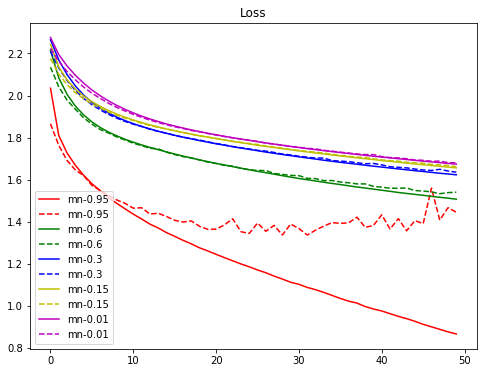

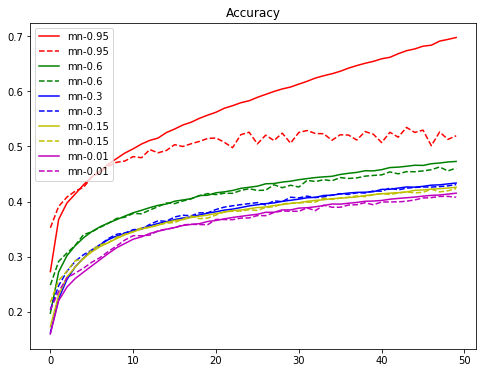

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

### <font color='red'>結論 : 好的 momentum 可以加速資料準確性</font>

# nesterov = False

In [11]:
# nesterov = False
results = {}
for mn in MOMENTUM:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with MN = %.3f" % (mn))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=False, momentum=mn)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "mn-%s" % str(mn)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with MN = 0.950
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================]

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 3s 66us/step - loss: 2.2166 - acc: 0.2011 - val_loss: 2.1341 - val_acc: 0.2593
Epoch 2/50
50000/50000 [==============================] - 3s 60us/step - loss: 2.0797 - acc: 0.2760 - val_loss: 2.0339 - val_acc: 0.2901
Epoch 3/50
50000/50000 [==============================] - 3s 60us/step - loss: 1.9994 - acc: 0.3051 - val_loss: 1.9712 - val_acc: 0.3130
Epoch 4/50
50000/50000 [==============================] - 3s 60us/step - loss: 1.9465 - acc: 0.3222 - val_loss: 1.9259 - val_acc: 0.3279
Epoch 5/50
50000/50000 [==============================] - 3s 60us/step - loss: 1.9076 - acc: 0.3348 - val_loss: 1.8928 - val_acc: 0.3394
Epoch 6/50
50000/50000 [==============================] - 3s 60us/step - loss: 1.8777 - acc: 0.3440 - val_loss: 1.8696 - val_acc: 0.3461
Epoch 7/50
50000/50000 [==============================] - 3s 59us/step - loss: 1.8538 - acc: 0.3529 - val_loss: 1.8451 - val_acc

50000/50000 [==============================] - 3s 57us/step - loss: 2.1626 - acc: 0.2311 - val_loss: 2.1256 - val_acc: 0.2476
Epoch 3/50
50000/50000 [==============================] - 3s 56us/step - loss: 2.0972 - acc: 0.2609 - val_loss: 2.0690 - val_acc: 0.2754
Epoch 4/50
50000/50000 [==============================] - 3s 56us/step - loss: 2.0470 - acc: 0.2816 - val_loss: 2.0248 - val_acc: 0.2841
Epoch 5/50
50000/50000 [==============================] - 3s 56us/step - loss: 2.0074 - acc: 0.2947 - val_loss: 1.9896 - val_acc: 0.2988
Epoch 6/50
50000/50000 [==============================] - 3s 56us/step - loss: 1.9748 - acc: 0.3049 - val_loss: 1.9593 - val_acc: 0.3096
Epoch 7/50
50000/50000 [==============================] - 3s 56us/step - loss: 1.9479 - acc: 0.3170 - val_loss: 1.9360 - val_acc: 0.3133
Epoch 8/50
50000/50000 [==============================] - 3s 56us/step - loss: 1.9258 - acc: 0.3259 - val_loss: 1.9145 - val_acc: 0.3290
Epoch 9/50
50000/50000 [============================

Epoch 4/50
50000/50000 [==============================] - 3s 59us/step - loss: 2.0496 - acc: 0.2767 - val_loss: 2.0316 - val_acc: 0.2831
Epoch 5/50
50000/50000 [==============================] - 3s 60us/step - loss: 2.0116 - acc: 0.2911 - val_loss: 1.9980 - val_acc: 0.2967
Epoch 6/50
50000/50000 [==============================] - 3s 60us/step - loss: 1.9808 - acc: 0.3046 - val_loss: 1.9725 - val_acc: 0.2992
Epoch 7/50
50000/50000 [==============================] - 3s 60us/step - loss: 1.9551 - acc: 0.3132 - val_loss: 1.9473 - val_acc: 0.3130
Epoch 8/50
50000/50000 [==============================] - 3s 59us/step - loss: 1.9328 - acc: 0.3223 - val_loss: 1.9265 - val_acc: 0.3268
Epoch 9/50
50000/50000 [==============================] - 3s 58us/step - loss: 1.9136 - acc: 0.3310 - val_loss: 1.9087 - val_acc: 0.3318
Epoch 10/50
50000/50000 [==============================] - 3s 58us/step - loss: 1.8969 - acc: 0.3379 - val_loss: 1.8939 - val_acc: 0.3416
Epoch 11/50
50000/50000 [===============

50000/50000 [==============================] - 3s 58us/step - loss: 2.0275 - acc: 0.2842 - val_loss: 2.0169 - val_acc: 0.2865
Epoch 6/50
50000/50000 [==============================] - 3s 60us/step - loss: 1.9984 - acc: 0.2970 - val_loss: 1.9898 - val_acc: 0.2932
Epoch 7/50
50000/50000 [==============================] - 3s 59us/step - loss: 1.9735 - acc: 0.3070 - val_loss: 1.9665 - val_acc: 0.3099
Epoch 8/50
50000/50000 [==============================] - 3s 57us/step - loss: 1.9521 - acc: 0.3176 - val_loss: 1.9464 - val_acc: 0.3168
Epoch 9/50
50000/50000 [==============================] - 3s 58us/step - loss: 1.9333 - acc: 0.3260 - val_loss: 1.9299 - val_acc: 0.3213
Epoch 10/50
50000/50000 [==============================] - 3s 59us/step - loss: 1.9167 - acc: 0.3319 - val_loss: 1.9146 - val_acc: 0.3313
Epoch 11/50
50000/50000 [==============================] - 3s 59us/step - loss: 1.9018 - acc: 0.3389 - val_loss: 1.8997 - val_acc: 0.3377
Epoch 12/50
50000/50000 [=========================

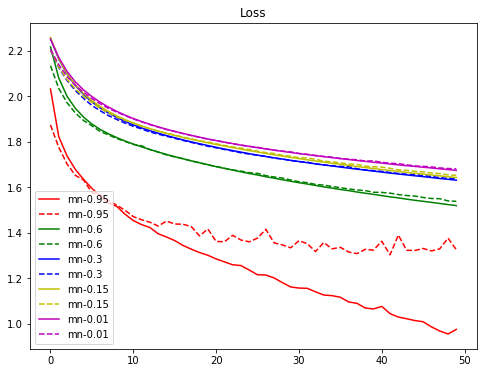

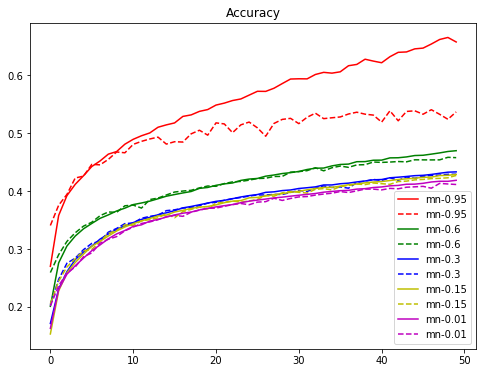

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()